# Embedding

##

### 2022-1 RecommenderSystem Project

#### Enviroment

- python ->	3.9.7
- pandas ->	1.4.1
- numpy ->	1.21.5
- nltk ->	3.7
- torch -> 1.10.2

#### Data

- beer_reviews.csv (<https://www.kaggle.com/datasets/rdoume/beerreviews>)

#### Author

- Lee Junhee

#### Reference

- <https://velog.io/@rsj9987/%EB%A6%AC%EB%B7%B0-%EB%B6%84%EC%84%9D%EC%9D%84-%ED%86%B5%ED%95%9C-%EB%A7%A5%EC%A3%BC-%EC%B6%94%EC%B2%9C-%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98#2-5-%ED%86%A0%ED%81%B0-%EA%B0%80%EC%A4%91%EC%B9%98-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%83%9D%EC%84%B1>

---

#### 데이터 살피기

필요한 패키지를 추가한다.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# 자연어 처리 라이브러리 토큰화를 위해 사용
import nltk
# nltk.tokenize.word_tokenize 함수를 사용하기 위해 딱 한번 주석을 해제하여 실행해야한다.
# nltk.download('punkt')

# 불용어를 위해 쓰이는 라이브러리
import requests
import re

from collections import Counter

from itertools import permutations
import random

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch

CSV 파일에서 데이터를 읽어 온다.

In [2]:
beerReviews = pd.read_csv("./data/merged_data.csv")

상위 5개의 데이터를 살펴본다.

In [3]:
beerReviews.head()

,Unnamed: 0,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,Description
0,10,163,Amstel Brouwerij B. V.,1010963392,3.0,2.0,3.0,fodeeoz,Light Lager,2.5,2.5,Amstel Light,3.5,436,ABV in the USA is 4.1%\t
1,18,163,Amstel Brouwerij B. V.,1010861086,2.5,3.0,3.0,jdhilt,Light Lager,2.0,2.0,Amstel Light,3.5,436,ABV in the USA is 4.1%\t
2,30,163,Amstel Brouwerij B. V.,1002109880,3.0,2.0,2.0,xXTequila,Light Lager,2.0,3.0,Amstel Light,3.5,436,ABV in the USA is 4.1%\t
3,40,163,Amstel Brouwerij B. V.,988202869,3.0,3.0,3.0,Brent,Light Lager,2.0,2.0,Amstel Light,3.5,436,ABV in the USA is 4.1%\t
4,750,163,Amstel Brouwerij B. V.,1264904623,3.5,2.5,3.5,brownbeer,Light Lager,3.0,3.0,Amstel Light,3.5,436,ABV in the USA is 4.1%\t


하위 5의 데이터를 살펴본다.

In [4]:
beerReviews.tail()

,Unnamed: 0,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,Description
452949,1683163,14359,The Defiant Brewing Company,1175746381,3.5,4.0,4.0,maddogruss,American IPA,4.0,4.0,India Pale Ale,6.2,35185,This ale is traditionally highly hopped and ro...
452950,1683164,14359,The Defiant Brewing Company,1171081089,4.0,4.5,4.0,dherling,American IPA,4.0,4.5,India Pale Ale,6.2,35185,Green Man India Pale Ale is delectably hoppy w...
452951,1683165,14359,The Defiant Brewing Company,1171081089,4.0,4.5,4.0,dherling,American IPA,4.0,4.5,India Pale Ale,6.2,35185,This ale is traditionally highly hopped and ro...
452952,1683166,14359,The Defiant Brewing Company,1170979828,4.0,4.0,4.5,cbl2,American IPA,4.0,4.0,India Pale Ale,6.2,35185,Green Man India Pale Ale is delectably hoppy w...
452953,1683167,14359,The Defiant Brewing Company,1170979828,4.0,4.0,4.5,cbl2,American IPA,4.0,4.0,India Pale Ale,6.2,35185,This ale is traditionally highly hopped and ro...


#### Embedding 과정

각 맥주들을 표현한 의미있는 Embedding을 위해 Description 열을 이용한다.

Description은 맥주의 설명을 적은 문장이므로, 각 문장의 단어들을 Embedding하고 결과를 이용하여 맥주를 표현하는 Embedding vector를 정의한다.

Description을 사용하기 전에 임의 데이터의 Description 값을 출력해본다.

In [5]:
def print_beer_with_description_by_id(dataIdx):
	global beerReviews
	print(f"idx: {dataIdx}\nbeer_name: { beerReviews['beer_name'].iloc[dataIdx] }\ndescription: {beerReviews['Description'].iloc[dataIdx]}\n")

print_beer_with_description_by_id(0)
print_beer_with_description_by_id(452952)

idx: 0
beer_name: Amstel Light
description: ABV in the USA is 4.1%	

idx: 452952
beer_name: India Pale Ale
description: Green Man India Pale Ale is delectably hoppy with a properly balanced body. Generous hop additions give it a wonderful bitterness and pleasant floral nose, while our combination of traditional British malts creates a rich, satisfying flavor and alluring copper color. This authentic English-style IPA is our flagship ale.	



두개의 데이터 중 상위의 데이터(Amstel Light)의 경우는 Description에서 맥주의 특징을 잘 설명하지 않고 있다. 아래의 데이터(India Pale Ale)는 Description에 맥주에 대한 설명히 자세하게 적혀있다.

위의 데이터의 경우, Embedding vector를 얻는 것이 힘들어 보이고 아래 데이터의 경우, 적절한 임베딩 벡터를 얻을 수 있을거라 예상한다.

임베딩을 위해서 각 문장을 수치화 해야한다. 문장을 수치화 하기 위한 방법으로 **Bag of Words 모델**을 사용하여 단어의 빈도수에 대한 집합으로 나타낸다. nltk 패키지를 사용하였다.

맥주의 정보만 갖고 있는 데이터 프레임 따로 뽑아낸다.

In [6]:
beersDuplicated = beerReviews[["beer_beerid", "beer_name", "beer_style", "beer_abv", "Description"]]
beersDuplicated

,beer_beerid,beer_name,beer_style,beer_abv,Description
0,436,Amstel Light,Light Lager,3.5,ABV in the USA is 4.1%\t
1,436,Amstel Light,Light Lager,3.5,ABV in the USA is 4.1%\t
2,436,Amstel Light,Light Lager,3.5,ABV in the USA is 4.1%\t
3,436,Amstel Light,Light Lager,3.5,ABV in the USA is 4.1%\t
4,436,Amstel Light,Light Lager,3.5,ABV in the USA is 4.1%\t
...,...,...,...,...,...
452949,35185,India Pale Ale,American IPA,6.2,This ale is traditionally highly hopped and ro...
452950,35185,India Pale Ale,American IPA,6.2,Green Man India Pale Ale is delectably hoppy w...
452951,35185,India Pale Ale,American IPA,6.2,This ale is traditionally highly hopped and ro...
452952,35185,India Pale Ale,American IPA,6.2,Green Man India Pale Ale is delectably hoppy w...


리뷰데이터에서 나온 데이터이기 때문에 같은 맥주가 중복되어 나타난다.

중복을 제거하여 맥주의 데이터프레임을 만든다.

In [7]:
beers = beersDuplicated.drop_duplicates()
beers

,beer_beerid,beer_name,beer_style,beer_abv,Description
0,436,Amstel Light,Light Lager,3.5,ABV in the USA is 4.1%\t
6,60990,Mogli,American Porter,8.5,'Oak Aged Imperial Porter Brewed with Chocolat...
263,20575,Hefeweizen,Hefeweizen,5.0,Formerly In-Heat Wheat\t
264,20575,Hefeweizen,Hefeweizen,5.0,An authentic example of a Bavarian Hefeweizen....
265,20575,Hefeweizen,Hefeweizen,5.0,"Our Hefeweizen is a light, unfiltered wheat be..."
...,...,...,...,...,...
452813,32985,Porter,American Porter,5.8,absence of hops gives Founders' robust porter...
452814,32985,Porter,American Porter,5.8,Our award winning Porter bridges the gap betwe...
452815,32985,Porter,American Porter,5.8,Our robust porter utilizes a myriad of dark ma...
452928,35185,India Pale Ale,American IPA,6.2,Green Man India Pale Ale is delectably hoppy w...


각 Description을 단어로 토큰화하고 정제한다.

명사와 형용사만을 사용하고, 영어로 된 단어만 검출하며, 맥주의 특징이 아니라고 생각하는 단어들을 삭제한다.

In [8]:
def text_tokenize(text):
    doc = nltk.tokenize.word_tokenize(text)
    tokens = []
    
    for word, tag in nltk.tag.pos_tag(doc):
        if tag in ['NN', 'JJ', 'JJR', 'JJS', ]:
            tokens.append(word)
    
    return tokens

def token_cleaning(tokens):
    comp = re.compile('[^A-Za-z]') # 영어로 된 단어만 검출
    cleaned = []
    for token in tokens:
        token = comp.sub('', token)
        if len(token) > 4:
            cleaned.append(token.lower()) # 검출된 단어 소문자로 통합하여 저장
    return cleaned

In [9]:
beers['tokens'] = beers['Description'].apply(text_tokenize)
beers['tokens'] = beers['tokens'].apply(token_cleaning)

beers.head()

C:\Users\jun\AppData\Local\Temp\ipykernel_9780\2085284390.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beers['tokens'] = beers['Description'].apply(text_tokenize)
C:\Users\jun\AppData\Local\Temp\ipykernel_9780\2085284390.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beers['tokens'] = beers['tokens'].apply(token_cleaning)


,beer_beerid,beer_name,beer_style,beer_abv,Description,tokens
0,436,Amstel Light,Light Lager,3.5,ABV in the USA is 4.1%\t,[]
6,60990,Mogli,American Porter,8.5,'Oak Aged Imperial Porter Brewed with Chocolat...,"[first, release, waxed]"
263,20575,Hefeweizen,Hefeweizen,5.0,Formerly In-Heat Wheat\t,[]
264,20575,Hefeweizen,Hefeweizen,5.0,An authentic example of a Bavarian Hefeweizen....,"[authentic, example, bavarian, cloudy, yeasty,..."
265,20575,Hefeweizen,Hefeweizen,5.0,"Our Hefeweizen is a light, unfiltered wheat be...","[light, unfiltered, wheat, wedge, lemon, thirt..."


token이 없는 데이터는 삭제한다.

In [10]:
beers = beers[beers['tokens'].map(lambda d: len(d)) > 0]
beers.head()

,beer_beerid,beer_name,beer_style,beer_abv,Description,tokens
6,60990,Mogli,American Porter,8.5,'Oak Aged Imperial Porter Brewed with Chocolat...,"[first, release, waxed]"
264,20575,Hefeweizen,Hefeweizen,5.0,An authentic example of a Bavarian Hefeweizen....,"[authentic, example, bavarian, cloudy, yeasty,..."
265,20575,Hefeweizen,Hefeweizen,5.0,"Our Hefeweizen is a light, unfiltered wheat be...","[light, unfiltered, wheat, wedge, lemon, thirt..."
266,20575,Hefeweizen,Hefeweizen,5.0,"Hundreds of years ago in Germany, wheat beers ...","[wheat, church, testament, light, flavor, trad..."
479,27666,Holiday Ale,Herbed / Spiced Beer,7.5,Two Roads Holiday Ale is inspired by the littl...,"[little, known, style, subset, small, farmhous..."


다른 Description을 가진 같은 맥주가 존재한다. 이를 해결하기 위해 이름을 묶고 각 Description의 token들을 concatenate해준다.

In [11]:
tokensByBeer = beers.groupby('beer_name')['tokens'].sum().reset_index()
beers = beers.groupby('beer_name')['beer_style'].sum().reset_index()

beers = beers.merge(tokensByBeer, on='beer_name')
beers

,beer_name,beer_style,tokens
0,# 100,American Barleywine,"[batch, wheat, chocolate, yeast, local, water]"
1,#9,Fruit / Vegetable Beer,"[secrecy, mysterious, unusual, palate, tongue,..."
2,'t Smisje BBBourgondier,Quadrupel (Quad),"[available, honor]"
3,10 Commandments,Belgian Strong Dark Ale,"[stronger, version, contemplative, alcohol, co..."
4,1100 Wheat Wine,Wheatwine,"[first, bourbon]"
...,...,...,...
1187,Zwickel,Keller Bier / Zwickel BierKeller Bier / Zwicke...,"[flagship, lager, zvickel, unfiltered, unpaste..."
1188,ZÔN,Witbier,"[summer, seasonal, interpretation, classic, be..."
1189,Éphémère (Apple),Fruit / Vegetable Beer,"[ephemeral, series, seasonal, fruit, refreshin..."
1190,Équinoxe Du Printemps,Scotch Ale / Wee Heavy,"[quinoxe, spring, equinox, quintessential, mar..."


In [12]:
allTokens = []
for tokens in beers['tokens']:
    allTokens += tokens

tokensWithCount = Counter(allTokens).most_common()
tokensWithCount = sorted(tokensWithCount, key=lambda x : x[1])
print(f"Part of tokensWithCount: {tokensWithCount[:10]}")
print(f"Number of tokens: {len(tokensWithCount)}")

Part of tokensWithCount: [('secrecy', 1), ('notquite', 1), ('stretch', 1), ('saint', 1), ('stray', 1), ('plato', 1), ('highalpha', 1), ('skull', 1), ('decree', 1), ('twostroke', 1)]
Number of tokens: 3568


token만 남겨서 맥주 Description에 대 어휘 집합을 생성한다.

index가 낮을 수록 Description에서의 출현 빈도수가 낮은 단어이며 높을 수록 출현 빈도수가 높은 단어이다.

In [13]:
vocabulary = []
for token, count in tokensWithCount:
        vocabulary.append(token)

WORDS_SIZE = len(vocabulary)
print(f"Part of vocabulary: {vocabulary[:10]}")
print(f"vocabulary size: {WORDS_SIZE}")

Part of vocabulary: ['secrecy', 'notquite', 'stretch', 'saint', 'stray', 'plato', 'highalpha', 'skull', 'decree', 'twostroke']
vocabulary size: 3568


tokens를 vocabulary의 index로 encoding한다.

In [14]:
def encode_tokens(tokens):
	global vocabulary
	encoded = []
	for index, token in enumerate(vocabulary):
		if token in tokens:
			encoded.append(index)
	return encoded

beers['encoded'] = beers['tokens'].apply(encode_tokens)
beers

,beer_name,beer_style,tokens,encoded
0,# 100,American Barleywine,"[batch, wheat, chocolate, yeast, local, water]","[3030, 3446, 3492, 3547, 3552, 3562]"
1,#9,Fruit / Vegetable Beer,"[secrecy, mysterious, unusual, palate, tongue,...","[0, 1, 1624, 2324, 2434, 2542, 2927, 3505, 3528]"
2,'t Smisje BBBourgondier,Quadrupel (Quad),"[available, honor]","[2571, 3460]"
3,10 Commandments,Belgian Strong Dark Ale,"[stronger, version, contemplative, alcohol, co...","[2, 3, 4, 1625, 2435, 2632, 2783, 2837, 3388, ..."
4,1100 Wheat Wine,Wheatwine,"[first, bourbon]","[3064, 3500]"
...,...,...,...,...
1187,Zwickel,Keller Bier / Zwickel BierKeller Bier / Zwicke...,"[flagship, lager, zvickel, unfiltered, unpaste...","[2218, 2219, 2291, 2529, 3429, 3450, 3524, 355..."
1188,ZÔN,Witbier,"[summer, seasonal, interpretation, classic, be...","[1616, 2308, 3088, 3298, 3358, 3390, 3471, 349..."
1189,Éphémère (Apple),Fruit / Vegetable Beer,"[ephemeral, series, seasonal, fruit, refreshin...","[1617, 1618, 1619, 1956, 1998, 2035, 2066, 227..."
1190,Équinoxe Du Printemps,Scotch Ale / Wee Heavy,"[quinoxe, spring, equinox, quintessential, mar...","[1620, 1621, 1622, 1726, 2222, 2333, 2358, 239..."


encoded갯수가 1인 맥주들 개수 파악 및 단어의 개수 시각화

In [15]:
print(f"Encoded length == 1 => {beers[beers['encoded'].map(lambda d: len(d)) == 1]['encoded'].count()}")

Encoded length == 1 => 41


Max count: 124


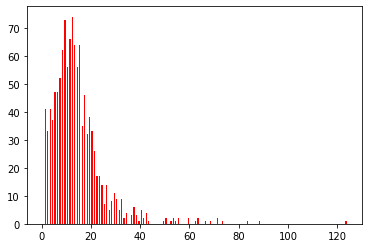

In [16]:
counts = beers['encoded'].map(lambda d: len(d)).to_list()
print(f'Max count: {max(counts)}')
bins = max(counts)
plt.hist(counts, bins=bins, range=(0, bins), rwidth=0.5, color="red")
plt.show()


**단어가 하나인 문장**들은 학습에 쓰이지 못한다.

일단 하나 이상의 단어를 가진 맥주의 설명에서, **맥주 하나가 가지는 단어들은 유사한 단어**라고 생각하고 각 단어의 페어를 만든다.

In [17]:
indexPairByBeers = []
for encoded in beers['encoded']:
	for indexPair in permutations(encoded, 2):
		indexPairByBeers.append(indexPair)
random.shuffle(indexPairByBeers)
print(f"The length of pairs: {len(indexPairByBeers)}")
print(indexPairByBeers[:50])


The length of pairs: 354502
[(3403, 3436), (3525, 1525), (2781, 3197), (3565, 3564), (3403, 3438), (3562, 3561), (3538, 2917), (2943, 3313), (3185, 258), (3483, 2753), (3521, 2384), (3434, 3557), (3557, 3567), (3564, 3444), (3540, 3394), (2423, 3553), (3030, 2545), (2952, 2240), (3476, 3450), (3454, 3169), (1443, 1445), (3556, 2818), (3514, 3084), (2424, 3487), (3487, 3567), (3448, 1001), (2361, 2989), (3355, 3194), (3484, 3513), (3428, 2852), (3523, 3552), (3526, 2393), (1366, 3544), (3393, 2452), (2799, 3565), (3378, 3022), (3427, 3201), (2499, 2511), (3261, 3282), (3543, 3488), (3477, 3129), (3400, 3567), (45, 2692), (2853, 3194), (3185, 3542), (3443, 3125), (3538, 232), (3538, 2643), (3483, 3537), (3505, 3366)]


In [18]:
class WordPairsDataset(Dataset):
	def __init__(self, pairs):
		self.pairs = pairs
	
	def __len__(self):
		return len(self.pairs)

	def __getitem__(self, idx):
		return self.pairs[idx]

train_num = len(indexPairByBeers)*7//10
print(f"The 70% of data is for trainning => number of data: {train_num}")
print(f"The 30% of data is for testing => number of data: {len(indexPairByBeers) - train_num}")
trainDataset = WordPairsDataset(indexPairByBeers[:train_num])
testDataset = WordPairsDataset(indexPairByBeers[train_num:])

The 70% of data is for trainning => number of data: 248151
The 30% of data is for testing => number of data: 106351


In [19]:
BATCH_SIZE = 128
trainDataLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True)
testDataLoader = DataLoader(testDataset, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
class WordEmbeddingNN(torch.nn.Module):
    def __init__(self, vocaSize, embeddingDim):
        super(WordEmbeddingNN, self).__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(vocaSize, embeddingDim),
            torch.nn.ReLU(),
            torch.nn.Linear(embeddingDim, vocaSize),
        )

    def forward(self, x):
        x = x.to(torch.float32)
        x = self.linear_relu_stack(x)
        return x

In [21]:
# TODO: 학습
def training(trainLoader, testLoader, network, lossFunc, optim, epoches = 20):
    train_losses_per_epoch = []
    test_losses_per_epoch = []
    
    train_accuracies = []
    test_accuracies = []
    
    
    for epoch in range(epoches):
                
        # 모델를 학습 중이라고 선언하기
        network.train()
        
        train_losses, train_correct = training_epoch(trainLoader, network, lossFunc, optim, epoch)
        
        # epoch 별로 loss 평균값, 정확도 구하기
        average_loss = np.mean(train_losses)
        train_losses_per_epoch.append(average_loss)
        
        train_accuracy = train_correct / len(trainLoader.dataset) * 100
        train_accuracies.append(train_accuracy)
        
        # epoch 별로 정확도 출력
        print(f'\nTraining set: Accuracy: {train_correct}/{len(trainLoader.dataset)} ({100. * train_correct / len(trainLoader.dataset):.0f}%)')
        
        ### 학습 중에 test 결과 보기
        
        # 모델 test 중인 것을 선언하기
        network.eval()
        
        with torch.no_grad():
            test_losses, test_accuracy = test_epoch(testLoader, network, lossFunc)

        test_losses_per_epoch.append(np.mean(test_losses))
        test_accuracies.append(test_accuracy)
        
    return train_losses_per_epoch, test_losses_per_epoch, train_accuracies, test_accuracies

In [22]:
def training_epoch(train_loader, network, loss_func, optimizer, epoch):
    train_losses = []
    train_correct = 0
    log_interval = 500
    
    for batch_idx, (inputLabel, outputLabel) in enumerate(train_loader):
        optimizer.zero_grad()
        inputLabelOnehot = torch.nn.functional.one_hot(inputLabel.to(torch.int64), WORDS_SIZE)
        outputs = network.forward(inputLabelOnehot)
        
        # loss_func 함수를 적용하여 loss를 구하고 저장하기
        loss = loss_func(outputs, outputLabel)
        train_losses.append(loss.item())

        # training accuracy 정확도 구하기 위해 맞는 샘플 개수 세기
        pred = torch.max(outputs, 1).indices
        train_correct += pred.eq(outputLabel).sum()

        # Gradinet 구하기
        loss.backward()

        # weight값 update 하기
        optimizer.step()

        # 학습 상황 출력
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(outputLabel)}/{len(train_loader.dataset)} ({100. * batch_idx*len(outputLabel) / len(train_loader.dataset):.0f}%)]\tLoss: {loss.item():.6f}')
            
    return train_losses, train_correct


In [23]:
def test_epoch(test_loader, network, loss_func):
    correct = 0
    
    test_losses = []
    
    with torch.no_grad():
        for batch_idx, (inputLabel, outputLabel) in enumerate(test_loader):
            inputLabelOnehot = torch.nn.functional.one_hot(inputLabel.to(torch.int64), WORDS_SIZE)

            # Forward propagration 계산하기.
            outputs = network.forward(inputLabelOnehot)

            # loss_func 함수를 적용하여 loss를 구하고 저장하기
            loss = loss_func(outputs, outputLabel)
            test_losses.append(loss.item())

            # Batch 별로 정확도 구하기
            pred = torch.max(outputs, 1).indices
            correct += pred.eq(outputLabel).sum()

        # 전체 정확도 구하기
        test_accuracy = 100. * correct / len(test_loader.dataset)

        #중간결과 출력
        print(f'Test set: Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')
    return test_losses, test_accuracy


In [24]:
lr = 0.001
betas = (0.9, 0.999)

def init_kaiming(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight.data, mode="fan_in")

net = WordEmbeddingNN(vocaSize=WORDS_SIZE, embeddingDim=100)
net.apply(init_kaiming)
lossFunc = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(net.parameters(), lr, betas)

trainingResult = training(trainDataLoader, testDataLoader, net, lossFunc, optim)

Train Epoch: 0 [0/248151 (0%)]	Loss: 8.180222
Train Epoch: 0 [64000/248151 (26%)]	Loss: 7.150164
Train Epoch: 0 [128000/248151 (52%)]	Loss: 6.853150
Train Epoch: 0 [192000/248151 (77%)]	Loss: 6.839989

Training set: Accuracy: 2811/248151 (1%)
Test set: Accuracy: 1191/106351 (1%)

Train Epoch: 1 [0/248151 (0%)]	Loss: 6.810853
Train Epoch: 1 [64000/248151 (26%)]	Loss: 6.671442
Train Epoch: 1 [128000/248151 (52%)]	Loss: 6.812731
Train Epoch: 1 [192000/248151 (77%)]	Loss: 6.677693

Training set: Accuracy: 3514/248151 (1%)
Test set: Accuracy: 1232/106351 (1%)

Train Epoch: 2 [0/248151 (0%)]	Loss: 6.429737
Train Epoch: 2 [64000/248151 (26%)]	Loss: 7.068776
Train Epoch: 2 [128000/248151 (52%)]	Loss: 6.655351
Train Epoch: 2 [192000/248151 (77%)]	Loss: 6.704960

Training set: Accuracy: 4247/248151 (2%)
Test set: Accuracy: 1122/106351 (1%)

Train Epoch: 3 [0/248151 (0%)]	Loss: 6.365269
Train Epoch: 3 [64000/248151 (26%)]	Loss: 6.471809
Train Epoch: 3 [128000/248151 (52%)]	Loss: 6.729543
Train Ep

In [25]:
# TODO: Embedding matrix를 통해 모든 단어들의 임베딩 벡터를 구함
for name, param in net.named_parameters():
	print(f'name:{name}')
	print(type(param))
	print(f'param.shape:{param.shape}')
	print(f'param.requries_grad:{param.requires_grad}')
	print('=====')

name:linear_relu_stack.0.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([100, 3568])
param.requries_grad:True
=====
name:linear_relu_stack.0.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([100])
param.requries_grad:True
=====
name:linear_relu_stack.2.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([3568, 100])
param.requries_grad:True
=====
name:linear_relu_stack.2.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([3568])
param.requries_grad:True
=====


In [26]:
W = net.get_parameter("linear_relu_stack.0.weight")
print(W.shape)

torch.Size([100, 3568])


In [27]:
def embedding(W, wordIdx):
	wordIdx = torch.tensor(wordIdx)
	idxOnehot = torch.nn.functional.one_hot(wordIdx.to(torch.int64), WORDS_SIZE)
	return torch.matmul(W, idxOnehot.to(torch.float))

wordEmbedding = []
for i in range(WORDS_SIZE):
	wordEmbedding.append(embedding(W, i).detach().numpy())

print(f"shape of word embeddings: {np.array(wordEmbedding).shape}")

shape of word embeddings: (3568, 100)


In [30]:
def get_embedding(indices):
	global wordEmbedding
	embedding = []
	for index in indices:
		embedding.append(wordEmbedding[index])
	return np.average(embedding, axis=0)

beers['embedding'] = beers['encoded'].apply(get_embedding)
print(f"number of beers embeddings: {len(beers['embedding'])}")
beers

number of beers embeddings: 1192


,beer_name,beer_style,tokens,encoded,embedding
0,# 100,American Barleywine,"[batch, wheat, chocolate, yeast, local, water]","[3030, 3446, 3492, 3547, 3552, 3562]","[-0.038733605, -0.141257, -0.1314186, -0.02864..."
1,#9,Fruit / Vegetable Beer,"[secrecy, mysterious, unusual, palate, tongue,...","[0, 1, 1624, 2324, 2434, 2542, 2927, 3505, 3528]","[-0.091067806, -0.2556749, 0.36461538, -0.2318..."
2,'t Smisje BBBourgondier,Quadrupel (Quad),"[available, honor]","[2571, 3460]","[-0.04127886, -0.10878571, 0.41264004, -0.2201..."
3,10 Commandments,Belgian Strong Dark Ale,"[stronger, version, contemplative, alcohol, co...","[2, 3, 4, 1625, 2435, 2632, 2783, 2837, 3388, ...","[-0.13049294, 0.011829153, 0.28523436, -0.2022..."
4,1100 Wheat Wine,Wheatwine,"[first, bourbon]","[3064, 3500]","[-0.28391176, -0.034813236, 0.2492991, -0.2185..."
...,...,...,...,...,...
1187,Zwickel,Keller Bier / Zwickel BierKeller Bier / Zwicke...,"[flagship, lager, zvickel, unfiltered, unpaste...","[2218, 2219, 2291, 2529, 3429, 3450, 3524, 355...","[0.17450069, 0.21993855, -0.28006345, -0.13167..."
1188,ZÔN,Witbier,"[summer, seasonal, interpretation, classic, be...","[1616, 2308, 3088, 3298, 3358, 3390, 3471, 349...","[0.069744915, -0.11311212, -0.25845426, 0.2089..."
1189,Éphémère (Apple),Fruit / Vegetable Beer,"[ephemeral, series, seasonal, fruit, refreshin...","[1617, 1618, 1619, 1956, 1998, 2035, 2066, 227...","[0.006539313, -0.2198533, 0.09618703, 0.149628..."
1190,Équinoxe Du Printemps,Scotch Ale / Wee Heavy,"[quinoxe, spring, equinox, quintessential, mar...","[1620, 1621, 1622, 1726, 2222, 2333, 2358, 239...","[0.31319603, 0.0055345288, 0.020530751, 0.1622..."


In [31]:
import pickle

beers.to_pickle('./data/beers_with_embedding.pkl')

In [60]:
import pickle

with open('./data/beers_with_embedding.pkl', 'rb') as f:
    beers = pickle.load(f)

beers = beers.loc[:,('beer_name','beer_style','embedding')]
beers = beers.set_index('beer_name')
beers.loc['10 Commandments']


beer_style                              Belgian Strong Dark Ale
embedding     [-0.13049294, 0.011829153, 0.28523436, -0.2022...
Name: 10 Commandments, dtype: object

In [73]:
def get_recommendations(name, n=3):
	global beers
	source = beers.loc[name]
	cos = torch.nn.CosineSimilarity(dim=0)
	similarity = []
	for beer in beers.index:
		src = torch.tensor(source['embedding'])
		trg = torch.tensor(beers.loc[beer]['embedding'])
		similarity.append(cos(src,trg))
	_, topKIndex = torch.tensor(similarity).topk(n+1)
	return beers.iloc[topKIndex[1:]]['beer_style']


In [77]:
print(beers.loc['10 Commandments']['beer_style'])
get_recommendations('10 Commandments')

Belgian Strong Dark Ale


beer_name
Judgment Day                          Quadrupel (Quad)
Girardin Gueuze 1882 (White Label)              Gueuze
Girardin Gueuze 1882 (Black Label)              Gueuze
Name: beer_style, dtype: object

위의 결과를 보면

10 Commandments라는 맥주의 beer_style은 Belgian Strong Dark Ale이며,

가장 유사한 3가지의 맥주는 위와 같고 beer_style은 Quadruple (Quad), Gueuze 두 종류로 나타난다.

Quadruple과 Gueuze 둘 다 벨기에 맥주의 일종이라고 한다.

따라서 Description 문장에서의 단어 특징을 바탕으로 추천해주고 있음을 알 수 있다.

![Quadruple.png](./asset/embedding_img.png)
![Quadruple.png](./asset/embedding_img1.png)